## Second task: Russet detection

The Mahalanobis Distance is a statistical measure used to determine the similarity of an observed data point to a distribution. In the context of the Fruit Analysis Project, the Mahalanobis Distance is applied to identify russet on fruit surfaces. Russet is a form of skin blemish, and its detection is crucial for assessing fruit quality. So, the first step was read the images.

In [45]:
import cv2 as cv
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import utils
import os

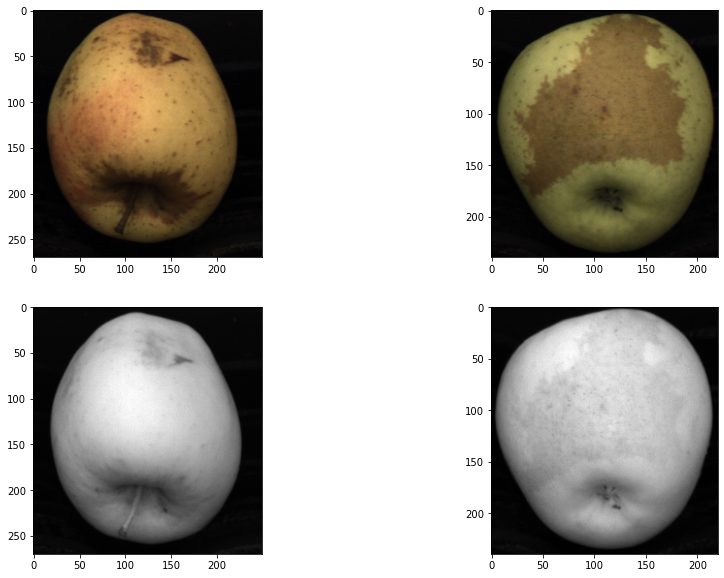

In [46]:
# Directorio de las imágenes
img_directory = 'fruit-inspection-images/second task/'

# Obtener una lista de nombres de archivo en el directorio
file_names = [file for file in os.listdir(img_directory) if os.path.isfile(os.path.join(img_directory, file))]

# Filtrar imágenes a color (C1) y blanco y negro (C0)
color_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_COLOR) for file in file_names if 'C1_' in file]
gray_images = [cv.imread(os.path.join(img_directory, file), cv.IMREAD_GRAYSCALE) for file in file_names if 'C0_' in file]

# Verificar si las imágenes se cargaron correctamente
assert all(image is not None for image in color_images), "Error al leer las imágenes en color"
assert all(image is not None for image in gray_images), "Error al leer las imágenes en blanco y negro"

# Mostrar las imágenes utilizando matplotlib
utils.show_image(color_images, gray_images)

Then, once again it was important to obtain the images mask, so, I plotted the histogram of the images in order to obtain the correct threshold value.

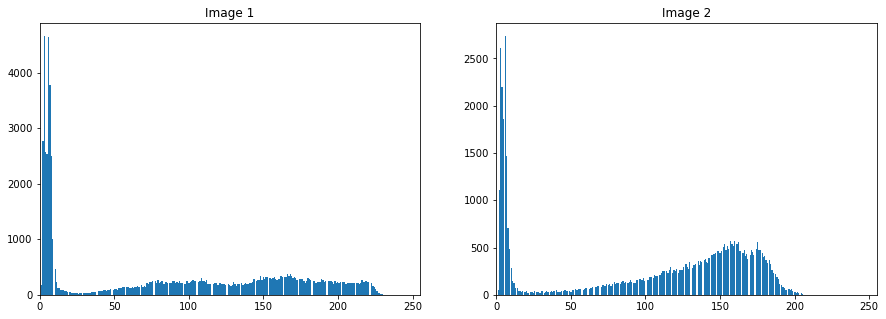

In [47]:
#Pixel Value histogram before smoothing
plt.figure(figsize=(15, 5))

for i, img in enumerate(gray_images):
    vals = img.flatten()
    plt.subplot(1,len(gray_images),i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

plt.show()

Likewise, the image was blurred to erase the noise that was visible in the previous histogram and thus obtain a better result.

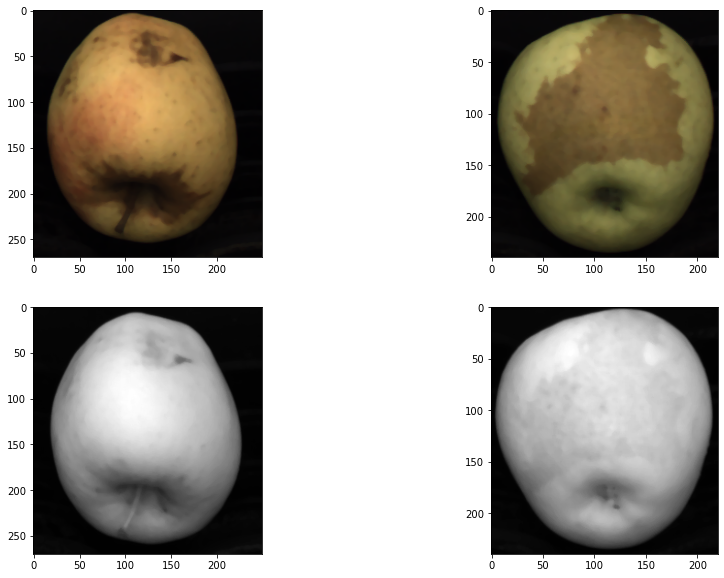

In [48]:
# Aplicar desenfoque para reducir el ruido
gray_images = [cv.medianBlur(img_g, 5) for img_g in gray_images]
color_images = [cv.medianBlur(img_c, 5) for img_c in color_images]
utils.show_image(color_images, gray_images)

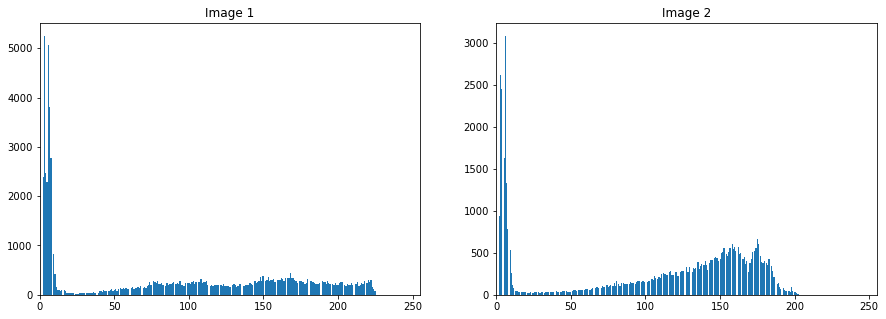

In [49]:
#Pixel Value histogram before smoothing
plt.figure(figsize=(15, 5))

for i, img in enumerate(gray_images):
    vals = img.flatten()
    plt.subplot(1,len(gray_images),i+1)
    plt.title("Image {0}".format(i+1))
    b, bins, patches = plt.hist(vals, 255)
    plt.xlim([0,255])

plt.show()

With this, we detected a threshold value for the three images around 50, since we tried to find the threshold automatically with the Otsu algorithm but obtained better results with the threshold of 50. It is then filled to have a perfect apple mask.

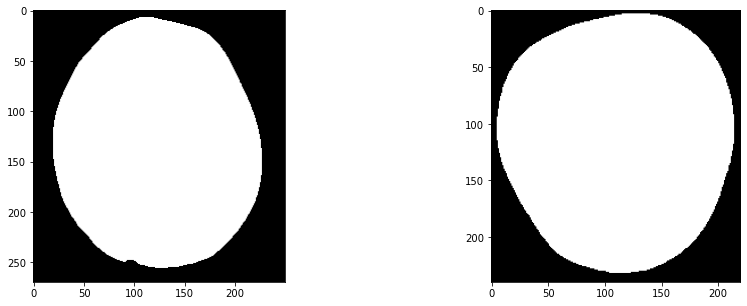

In [50]:
# Umbralizar la imagen
masks = []
i = 0;
for img in gray_images:
    ret, th1 = cv.threshold(img, 50, 255, cv.THRESH_BINARY)

    # Encontrar contornos en la imagen umbralizada
    contornos, _ = cv.findContours(th1, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

    # Crear una máscara inicial con el mismo tamaño que la imagen
    mask = np.zeros_like(img)

    # Dibujar los contornos en la máscara
    cv.drawContours(mask, contornos, -1, (255), thickness=cv.FILLED)
    
    # Encontrar un punto dentro de la fruta
    centroide = contornos[0].mean(axis=0)[0].astype(int)

    # Aplicar flood-fill para llenar los agujeros dentro del contorno
    cv.floodFill(mask, None, tuple(centroide), 255)
    masks.append(mask)
    i += 1

utils.show_gray_image(masks)

Once the masks are applied on the original image, we try to change the color space using BGR, HSV, HLS and LUV in order to observe with which space we obtain the best result.

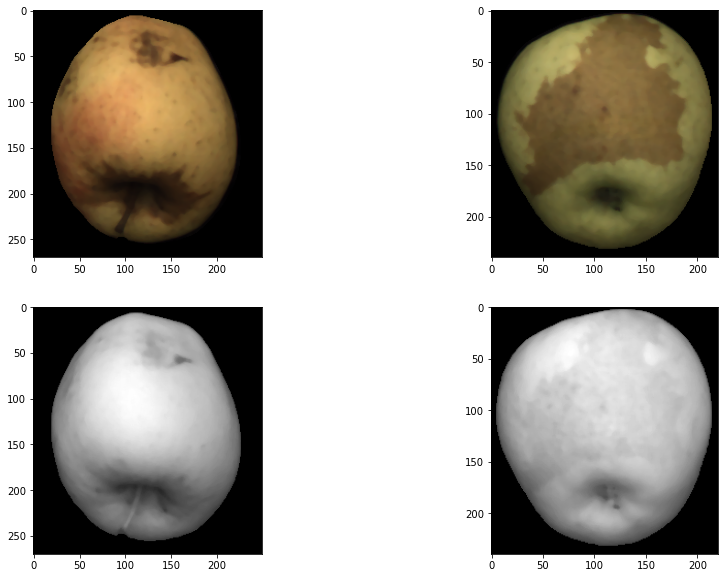

In [51]:
# Aplicar AND lógico entre la máscara y la imagen original
interes_bn = []
interes_c = []
for mask, img_color, img_gray in zip(masks, color_images, gray_images):
    interes_bn.append(cv.bitwise_and(img_gray, mask))
    interes_c.append(cv.bitwise_and(img_color, img_color, mask = mask))
    
utils.show_image(interes_c,interes_bn)

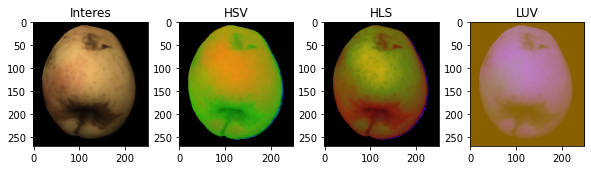

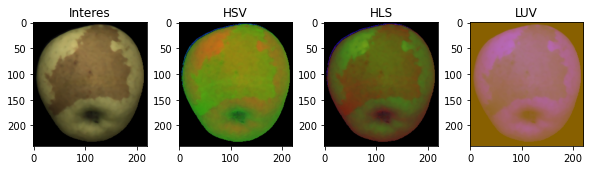

In [52]:
i = 0
img_hsv = []
img_hls = []
img_luv = []
for img_roi in interes_c:
    img_hsv.append(cv.cvtColor(img_roi, cv.COLOR_BGR2HSV))
    img_hls.append(cv.cvtColor(img_roi, cv.COLOR_BGR2HLS))
    img_luv.append(cv.cvtColor(img_roi, cv.COLOR_BGR2LUV))
    plt.figure(figsize = (10,5))
    plt.subplot(2,4,1+4*i)
    plt.imshow(img_roi[:,:,::-1])
    plt.title('Interes')
    plt.subplot(2,4,2+4*i)
    plt.imshow(img_hsv[i][:,:,::-1])
    plt.title('HSV')
    plt.subplot(2,4,3+4*i)
    plt.imshow(img_hls[i][:,:,::-1])
    plt.title('HLS')
    plt.subplot(2,4,4+4*i)
    plt.imshow(img_luv[i][:,:,::-1])
    plt.title('LUV')
    i += 1
plt.show()    

Samples of the russet skin are collected from various images. The samples are transformed into the chosen color space too (e.g., HSV) to create a reference color distribution. The mean and covariance matrix of these samples are calculated.

For each pixel in the fruit images, the Mahalanobis Distance is computed based on its color values and the reference color distribution. The formula for Mahalanobis Distance is given by:

$D_M = \sqrt{ (x-\mu)^T\Sigma^{-1}(x-\mu)}$

where:
* $x$ is the vector of color values for a pixel.
* $\mu$ is the mean vector of the reference color distribution.
* $\Sigma^{-1}$ is the inverse covariance matrix of the reference color distribution.
* $(x-\mu)^T$ the trasspose value

In [53]:
def mahalanobis(image, mask, color_space, file):
    # Calcular el vector de color promedio y la matriz de covarianza de la russet
    carpeta_imagenes = "fruit-inspection-images/second task/Russet/" + file
    imagenes = utils.cargar_imagenes(carpeta_imagenes)
    cv.waitKey(0)
    cv.destroyAllWindows()
    if color_space == "hsv":
        imagenes = [cv.cvtColor(img, cv.COLOR_BGR2HSV) for img in imagenes]
    elif color_space == "hls":
        imagenes = [cv.cvtColor(img, cv.COLOR_BGR2HLS) for img in imagenes]
    elif color_space == "luv":
        imagenes = [cv.cvtColor(img, cv.COLOR_BGR2LUV) for img in imagenes]
    
    imagenes = [img.reshape((-1, 3)) for img in imagenes]
    imagenes = np.concatenate(imagenes, axis=0)

    mean_russet = np.mean(imagenes, axis=0)
    
    mean_color_reference = np.uint8([[mean_russet]])
    mean_color_reference_bgr = cv.cvtColor(mean_color_reference, cv.COLOR_LAB2BGR)[0][0]
    print("Color de referencia (" ,color_space, "):", mean_color_reference_bgr)
    
    covariance_russet = np.cov(imagenes, rowvar=False)
    inv_covariance_russet = np.linalg.inv(covariance_russet)
    
    # Calcular la distancia de Mahalanobis para cada píxel de la imagen
    distance = np.zeros(image.shape[:2])
    for i in range(mask.shape[0]):
        for j in range(mask.shape[1]):
            pixel = image[i,j]
            distance[i,j] = np.sqrt(np.dot(np.dot(np.transpose(pixel - mean_russet), inv_covariance_russet), pixel - mean_russet))

    # Establecer un umbral para la distancia de Mahalanobis
    threshold_mahalanobis = 2.2
    mask_final = (distance > threshold_mahalanobis).astype(np.uint8) * 255

    # Aplicar la máscara resultante a la imagen original
    result_image = cv.bitwise_and(image, image, mask=mask_final)
    
    return result_image

In order to obtain the average color of mahalanobis, images of both blocks were extracted from different areas of the russet because in order to apply mahalanobis it is necessary to have a training stage in the system, so manually I obtained three groups of images, the first one from the fruit number 1, number 2 and the 2 combined and showing the result of each one with its respective group of images.
After this, it was important to find a threshold value to get the best possibles results.

#### First group of images

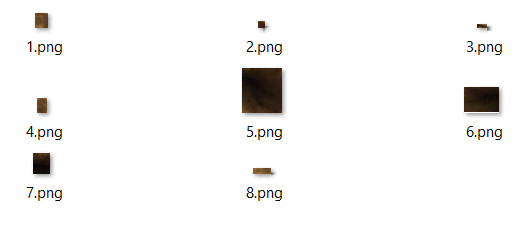

Color de referencia ( bgr ): [133  56   0]
Color de referencia ( hsv ): [128  21   0]
Color de referencia ( hls ): [37 47  0]
Color de referencia ( luv ): [ 8 43  0]


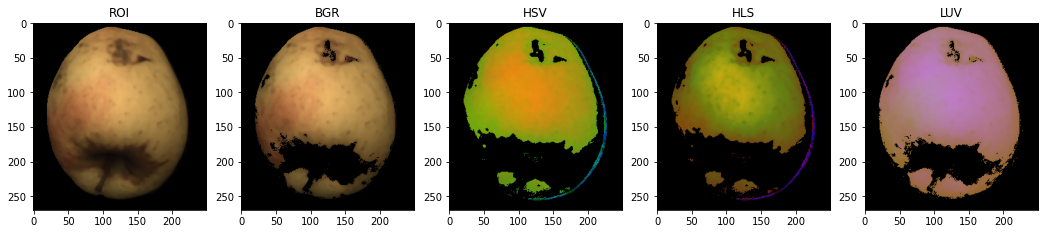

In [54]:
bgr = mahalanobis(interes_c[0],masks[0],"bgr","1")
hsv = mahalanobis(img_hsv[0],masks[0],"hsv","1")
hls = mahalanobis(img_hls[0],masks[0],"hls","1")
luv = mahalanobis(img_luv[0],masks[0],"luv","1")

plt.figure(figsize=(18,9))
plt.subplot(2,5,1)
plt.title('ROI')
plt.imshow(interes_c[0][:,:,::-1])
plt.subplot(2,5,2)
plt.title('BGR')
plt.imshow(bgr[:,:,::-1])
plt.subplot(2,5,3)
plt.title('HSV')
plt.imshow(hsv[:,:,::-1])
plt.subplot(2,5,4)
plt.title('HLS')
plt.imshow(hls[:,:,::-1])
plt.subplot(2,5,5)
plt.title('LUV')
plt.imshow(luv[:,:,::-1])

#### Second group of images

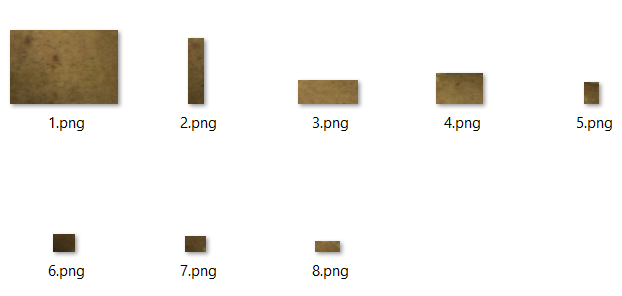

Color de referencia ( bgr ): [62 61  0]
Color de referencia ( hsv ): [34 16 34]
Color de referencia ( hls ): [64 38  0]
Color de referencia ( luv ): [ 34 105  85]


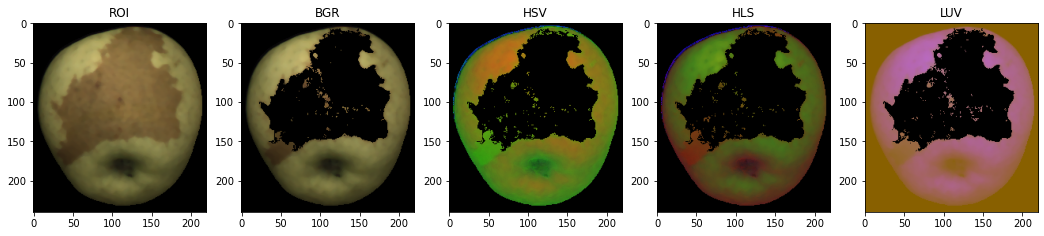

In [55]:
bgr = mahalanobis(interes_c[1],masks[1],"bgr","2")
hsv = mahalanobis(img_hsv[1],masks[1],"hsv","2")
hls = mahalanobis(img_hls[1],masks[1],"hls","2")
luv = mahalanobis(img_luv[1],masks[1],"luv","2")

plt.figure(figsize=(18,9))
plt.subplot(2,5,1)
plt.title('ROI')
plt.imshow(interes_c[1][:,:,::-1])
plt.subplot(2,5,2)
plt.title('BGR')
plt.imshow(bgr[:,:,::-1])
plt.subplot(2,5,3)
plt.title('HSV')
plt.imshow(hsv[:,:,::-1])
plt.subplot(2,5,4)
plt.title('HLS')
plt.imshow(hls[:,:,::-1])
plt.subplot(2,5,5)
plt.title('LUV')
plt.imshow(luv[:,:,::-1])

#### Both groups combined

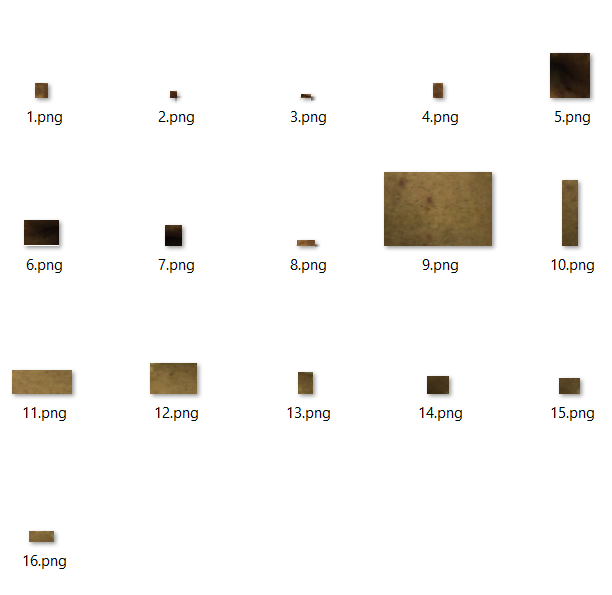

Color de referencia ( bgr ): [78 59  0]
Color de referencia ( hsv ): [53 14 22]
Color de referencia ( hls ): [57 40  0]
Color de referencia ( luv ): [29 91 67]
Color de referencia ( bgr ): [78 59  0]
Color de referencia ( hsv ): [53 14 22]
Color de referencia ( hls ): [57 40  0]
Color de referencia ( luv ): [29 91 67]


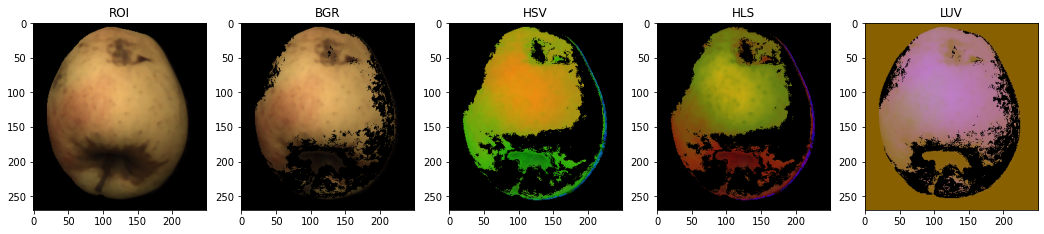

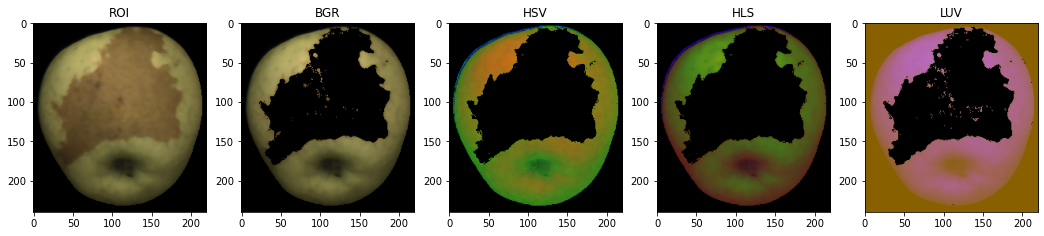

In [56]:
bgr = [] 
hsv = []
hls = []
luv = []
for i in range(len(interes_c)):
    bgr.append(mahalanobis(interes_c[i],masks[i],"bgr","all"))
    hsv.append(mahalanobis(img_hsv[i],masks[i],"hsv","all"))
    hls.append(mahalanobis(img_hls[i],masks[i],"hls","all"))
    luv.append(mahalanobis(img_luv[i],masks[i],"luv","all"))

for i in range(len(bgr)):
    plt.figure(figsize=(18,9))
    plt.subplot(2,5,1)
    plt.title('ROI')
    plt.imshow(interes_c[i][:,:,::-1])
    plt.subplot(2,5,2)
    plt.title('BGR')
    plt.imshow(bgr[i][:,:,::-1])
    plt.subplot(2,5,3)
    plt.title('HSV')
    plt.imshow(hsv[i][:,:,::-1])
    plt.subplot(2,5,4)
    plt.title('HLS')
    plt.imshow(hls[i][:,:,::-1])
    plt.subplot(2,5,5)
    plt.title('LUV')
    plt.imshow(luv[i][:,:,::-1])

It is possible to see that apple 1 performs better with the group of images containing only images of its russet, while with the second one, the performance is better when the images of both apples are used.